In [ ]:
### training of task adapter
!pip -q install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.5 MB/s eta 0:00:00


In [ ]:
!pip -q install --upgrade torch torchvision torchaudio

In [ ]:
!pip install -qq adapters datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 65.8 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, AutoConfig
import torch
from adapters import AutoAdapterModel
import numpy as np
from transformers import TrainingArguments, EvalPrediction
from adapters import AdapterTrainer
from sklearn.metrics import f1_score

In [ ]:
from datasets import load_dataset, DatasetDict

In [ ]:
#load dataset MBIB
dataset = load_dataset("mediabiasgroup/mbib-base")
#dataset = load_dataset("rotten_tomatoes")
dataset.num_rows

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.22k [00:00<?, ?B/s]

mbib-aggregated/cognitive-bias.csv:   0%|          | 0.00/851k [00:00<?, ?B/s]

mbib-aggregated/fake-news.csv:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

mbib-aggregated/gender-bias.csv:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

hate-speech.csv:   0%|          | 0.00/99.0M [00:00<?, ?B/s]

linguistic-bias.csv:   0%|          | 0.00/121M [00:00<?, ?B/s]

mbib-aggregated/political-bias.csv:   0%|          | 0.00/4.32M [00:00<?, ?B/s]

mbib-aggregated/racial-bias.csv:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

mbib-aggregated/text-level-bias.csv:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating cognitive_bias split:   0%|          | 0/7092 [00:00<?, ? examples/s]

Generating fake_news split:   0%|          | 0/8542 [00:00<?, ? examples/s]

Generating gender_bias split:   0%|          | 0/17940 [00:00<?, ? examples/s]

Generating hate_speech split:   0%|          | 0/339010 [00:00<?, ? examples/s]

Generating linguistic_bias split:   0%|          | 0/401862 [00:00<?, ? examples/s]

Generating political_bias split:   0%|          | 0/17704 [00:00<?, ? examples/s]

Generating racial_bias split:   0%|          | 0/9788 [00:00<?, ? examples/s]

Generating text_level_bias split:   0%|          | 0/9018 [00:00<?, ? examples/s]

{'cognitive_bias': 7092,
 'fake_news': 8542,
 'gender_bias': 17940,
 'hate_speech': 339010,
 'linguistic_bias': 401862,
 'political_bias': 17704,
 'racial_bias': 9788,
 'text_level_bias': 9018}

In [ ]:
## shuffling dataset split of respective bias
dataset1=dataset['text_level_bias'].shuffle(seed=42)

In [ ]:
# replacing the nan value in dataset1['text']  with ' ' (space)

dataset1 = dataset1.map(lambda examples: {'text': [str(x).replace('nan', ' ') for x in examples['text']]}, batched=True)


Map:   0%|          | 0/17704 [00:00<?, ? examples/s]

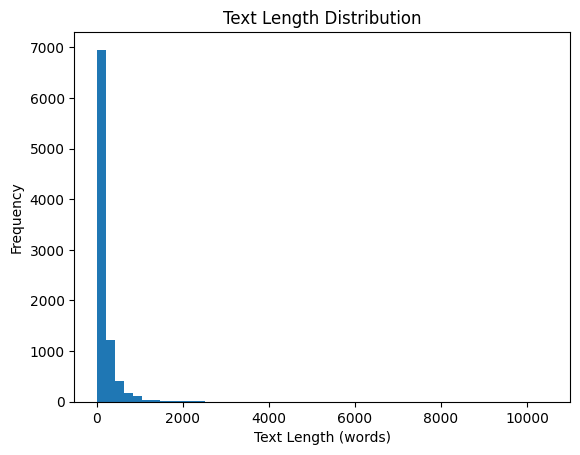

In [ ]:
# give me text length distribution of dataset1

#text_lengths = [len(example) for example in dataset1['text'] if example is not None]
text_lengths = [len(example) for example in dataset1['text'] ]

import matplotlib.pyplot as plt
plt.hist(text_lengths, bins=50)
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()


In [ ]:
#generate split of dataset1 into train, dev, test

dataset1 = dataset1.train_test_split(test_size=0.4, seed=42,shuffle=False)
dataset1['test'] = dataset1['test'].train_test_split(test_size=0.5, seed=42,shuffle=False)
dataset1['validation'] = dataset1['test']['train']
dataset1['test'] = dataset1['test']['test']


In [ ]:
#from transformers import RobertaTokenizer

#tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-2022-154m")
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base-mnli")
#tokenizer(comments, return_tensors="pt", padding=True, truncation=True, max_length=512)

#model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# # tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# from transformers import DataCollatorWithPadding



# # No need to set padding in tokenizer, DataCollator will handle it
# inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)

# When using a DataLoader, the DataCollator will take care of padding the batch

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  #return tokenizer(, max_length=512, truncation=True, padding="max_length")
  return tokenizer(batch["text"], padding= True,truncation=True, max_length=512)

# Encode the input data
dataset1 = dataset1.map(encode_batch, batched=True)
# The transformers model expects the target class column to be named "labels"
dataset1 = dataset1.rename_column(original_column_name="label", new_column_name="labels")
# Transform to pytorch tensors and only output the required columns
dataset1.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Importing from quanto will be deprecated in v4.47. Please install optimum-quanto instrad `pip install optimum-quanto`


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Map:   0%|          | 0/5410 [00:00<?, ? examples/s]

Map:   0%|          | 0/1804 [00:00<?, ? examples/s]

Map:   0%|          | 0/1804 [00:00<?, ? examples/s]

In [ ]:
## Configuration and pre-trained model is being downloaded

# config = AutoConfig.from_pretrained("cardiffnlp/twitter-roberta-base-2022-154m")
# model = AutoAdapterModel.from_pretrained(
#     "cardiffnlp/twitter-roberta-base-2022-154m",
#     config=config,
# )
config = AutoConfig.from_pretrained("microsoft/deberta-base-mnli")
model = AutoAdapterModel.from_pretrained(
    "microsoft/deberta-base-mnli",
    config=config,
)

pytorch_model.bin:   0%|          | 0.00/557M [00:00<?, ?B/s]

Some weights of DebertaAdapterModel were not initialized from the model checkpoint at microsoft/deberta-base-mnli and are newly initialized: ['deberta.encoder.layer.0.attention.self.in_proj.bias', 'deberta.encoder.layer.1.attention.self.in_proj.bias', 'deberta.encoder.layer.10.attention.self.in_proj.bias', 'deberta.encoder.layer.11.attention.self.in_proj.bias', 'deberta.encoder.layer.2.attention.self.in_proj.bias', 'deberta.encoder.layer.3.attention.self.in_proj.bias', 'deberta.encoder.layer.4.attention.self.in_proj.bias', 'deberta.encoder.layer.5.attention.self.in_proj.bias', 'deberta.encoder.layer.6.attention.self.in_proj.bias', 'deberta.encoder.layer.7.attention.self.in_proj.bias', 'deberta.encoder.layer.8.attention.self.in_proj.bias', 'deberta.encoder.layer.9.attention.self.in_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Add a new adapter

model.add_adapter("text_level_bias_deberta-mnli", config="seq_bn")

# Add a matching classification head
model.add_classification_head(
    "text_level_bias_deberta-mnli",
    num_labels=2,
    id2label={ 0:0, 1:1}
  )

# Activate the adapter
model.train_adapter("text_level_bias_deberta-mnli")


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import numpy as np
from transformers import TrainingArguments, EvalPrediction, EarlyStoppingCallback
from adapters import AdapterTrainer
from sklearn.metrics import f1_score

training_args = TrainingArguments(
    learning_rate=1.2e-4,
    num_train_epochs=6,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    #logging_steps=200,
    output_dir="./training_output",
    #overwrite_output_dir=True,
    load_best_model_at_end=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
    report_to="none"
)

def compute_metrics(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  f1 = f1_score(p.label_ids, preds, average='macro')
  return {
      'macro_f1': f1,
  }

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset1["train"],
    eval_dataset=dataset1["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1
1,0.608200,0.559362,0.725745
2,0.545300,0.523120,0.765071
3,0.469000,0.579683,0.756835
4,0.413700,0.550146,0.774523
5,0.415000,0.603320,0.765814


/usr/local/lib/python3.10/dist-packages/adapters/loading.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_file, map_location="cpu")


TrainOutput(global_step=3385, training_loss=0.48083376637941977, metrics={'train_runtime': 3718.8386, 'train_samples_per_second': 8.729, 'train_steps_per_second': 1.092, 'total_flos': 8418605479015872.0, 'train_loss': 0.48083376637941977, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5481245517730713,
 'eval_macro_f1': 0.7484775320248218,
 'eval_runtime': 106.1683,
 'eval_samples_per_second': 33.353,
 'eval_steps_per_second': 4.173,
 'epoch': 6.0}

In [ ]:


# Define your compute_metrics function
def compute_macro_f1(pred):
  labels = pred.label_ids
  preds = np.argmax(pred.predictions, axis=1)
  f1 = f1_score(labels, preds, average='macro')
  return {
      'macro-f1': f1,
  }

# Evaluate on the test set using predict and compute_macro_f1
predictions = trainer.predict(dataset1["test"])
metrics = compute_macro_f1(predictions)

print(metrics) # Print the macro-F1 score

{'macro-f1': 0.7560387898815846}


In [ ]:
# prompt: login huggingface account with hf api

from huggingface_hub import notebook_login
notebook_login()


In [1]:
##'mediabiasgroup/mbib-base'

In [ ]:
##Upload task adapters to huggingface-hub
model.push_adapter_to_hub(
    "text_level_bias_deberta-mnli",
    "text_level_bias_deberta-mnli",
    datasets_tag='mediabiasgroup/mbib-base'
)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model_head.bin:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

pytorch_adapter.bin:   0%|          | 0.00/3.60M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/SOUMYADEEPSAR/text_level_bias_deberta-mnli/commit/aff8afb03f0e73c874eb9dc899cee363f5d985ac', commit_message='Upload model', commit_description='', oid='aff8afb03f0e73c874eb9dc899cee363f5d985ac', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
##Inference on test dataset
from adapters import AutoAdapterModel
from transformers import AutoTokenizer

model = AutoAdapterModel.from_pretrained("microsoft/deberta-base-mnli")
adapter_name = model.load_adapter("SOUMYADEEPSAR/text_level_bias_deberta-mnli", set_active=True)
tokenizer=AutoTokenizer.from_pretrained("microsoft/deberta-base-mnli")

# outputs = model(**input_data)

# # Retrieve the predicted class label
# predicted = torch.argmax(outputs[0]).item()
# #assert predicted == 1

Importing from quanto will be deprecated in v4.47. Please install optimum-quanto instrad `pip install optimum-quanto`
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/557M [00:00<?, ?B/s]

Some weights of DebertaAdapterModel were not initialized from the model checkpoint at microsoft/deberta-base-mnli and are newly initialized: ['deberta.encoder.layer.0.attention.self.in_proj.bias', 'deberta.encoder.layer.1.attention.self.in_proj.bias', 'deberta.encoder.layer.10.attention.self.in_proj.bias', 'deberta.encoder.layer.11.attention.self.in_proj.bias', 'deberta.encoder.layer.2.attention.self.in_proj.bias', 'deberta.encoder.layer.3.attention.self.in_proj.bias', 'deberta.encoder.layer.4.attention.self.in_proj.bias', 'deberta.encoder.layer.5.attention.self.in_proj.bias', 'deberta.encoder.layer.6.attention.self.in_proj.bias', 'deberta.encoder.layer.7.attention.self.in_proj.bias', 'deberta.encoder.layer.8.attention.self.in_proj.bias', 'deberta.encoder.layer.9.attention.self.in_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

head_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

pytorch_adapter.bin:   0%|          | 0.00/3.60M [00:00<?, ?B/s]

pytorch_model_head.bin:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/adapters/loading.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_file, map_location="cpu")


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
from tqdm.auto import tqdm
import torch

In [ ]:
pred=[]
for i in tqdm(range(len(dataset1['test']))):
  input_data = tokenizer(dataset1['test']['text'][i], return_tensors="pt",truncation=True,max_length=512)
  outputs = model(**input_data)
  predicted = torch.argmax(outputs[0]).item()
  pred.append(predicted)


  0%|          | 0/1804 [00:00<?, ?it/s]

In [ ]:
actual=dataset1['test']['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.75      0.76      0.76       899
           1       0.76      0.74      0.75       905

    accuracy                           0.75      1804
   macro avg       0.75      0.75      0.75      1804
weighted avg       0.75      0.75      0.75      1804



In [ ]:
from sklearn.metrics import  f1_score
print(f1_score(actual, pred, average='macro'))

0.7533131320394548
